Author: Hexin Liang
Date Created: 2023/07/04

The purpose of this code is to investigate how nonlinear choice selectivity (switch signal) contributes to the population encoding of choice history, which is fundamental for flexible decision-making. We first generated surrogate neural data that have different population encoding properties of linear and nonlinear choice selectivty, and then decode the choice history across two successive trials. 

The detailed procedures are as follows:
1. Split the experimental data into two halves, one half as training data, the other half as        testing data and for generating surrogate data.
2. Apply linear SVM to the training data, to classify the current choice, the previous choice,      switch or stay, and 4-way classification of the choice sequence across two successive trials.
3. Generate surrogate data: 
   1) Gaussianize the spike counts data by rank transforming the spike counts and applying the         inverse of the CDF for a normal distribution . 
   2) Fit a linear regression model to the gaussianized neural activity, obtained the regression       coefficients for each task variable and the residual sum of squares (RSS) for each neuron. 
   3) Perform three different types of surrogate data. 
       a) Use the same regression coefficients.
       b) Remove the switch signal by setting the regression coefficient of the switch variable             to be 0 for each neuron.
       c) Change the correlation structure between the switch and the current choice. Shuffle the           regression coefficients of the switch signal across neurons, so that its correlation             with the regression coefficients of the current choice takes the target value, ranging           from the range [-1, 1]. 
       We then multiply the new design matrix with the same task variables, and plus a gaussian          noise with variance equals RSS. This generates neural activities with designed encoding          properties in a gaussianized form. 
   4) Rank transform the neural activity from 3) back to the spike counts following the original       distribution in the experimental data. 
4. Calculated the decoding accuracy for the experimental testing data, and three types of            surrogate that are generated from the experimental data. 


In [2]:
import mat4py
import pandas as pd
import numpy as np
import scipy
import scipy.io as sio
import math
import warnings
import warnings
import time
from itertools import combinations
from itertools import product

from numpy import linalg as LA
import statsmodels.api as sm
from statsmodels.formula.api import ols 
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.utils import resample

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

In [13]:
# load preprocessed behavioral + neural data (matlab file)

# probablistic reversal learning task
data = mat4py.loadmat('PRL_both_target_-500_500_250_1500_spkcounts_norm0.mat')
PRL = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
PRL.rename(columns=varName,inplace=True)
PRL.dropna(inplace=True)
ts = PRL.shape[1] - len(Var)
PRL_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Col','PreCol','RC','PRC','ColInter',
    'Rwd','PreRwd','POS','ChosenMag','UnchosenMag','LMag','HVL','SwitchHVL']

# matching pennies task
data = mat4py.loadmat('MP_feedback_-500_500_250_1500_spkcounts_norm0.mat')
MP = pd.DataFrame.from_dict(data['Data'])
Var = data['Var']
varName = { i : Var[i] for i in range(len(Var)) }
MP.rename(columns=varName,inplace=True)
MP.dropna(inplace=True)
MP_regressors = ['Loc','PreLoc','RL','PRL','LocInter','Rwd','PreRwd']

In [3]:
def split_data(data, var, seed):
    
    """
    Half-split the experimental data for each behavioral condition
    
    Args:
        data: pandas dataframe, has all the behavioral and neural data from a task;
              each row includes the spike counts of one neuron throughout different epochs within one trial,
              and the corresponding behavioral variables, and recording details from that trial.
        var:  choice variable, 'Col' for target color or 'Loc' for target location

        
    Returns:
        train: one half of the data
        test: the other half
    
    """
    
    data.reset_index(inplace=True,drop=True)  
    cell_num = data.cellid.unique()
    kf = KFold(n_splits=2, shuffle=True,random_state=seed)
    train_ind = np.array([])
    test_ind = np.array([])
    
    for var1_ind,val1 in enumerate(np.unique(data[var])):  
        for var2_ind,val2 in enumerate(np.unique(data['Pre'+var])):
            for var3_ind,val3 in enumerate(np.unique(data['PreRwd'])):

                temp = data[(data[var]==val1) & (data['Pre'+var]==val2) & (data['PreRwd']==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
                    trialNum = np.array(cData.index)

                    c_train_ind, c_test_ind = list(kf.split(trialNum))[0]
                    train_ind = np.append(train_ind, trialNum[c_train_ind])
                    test_ind = np.append(test_ind, trialNum[c_test_ind])

    train = data.iloc[train_ind,:]
    test = data.iloc[test_ind,:]
    train.reset_index(inplace=True,drop=True)
    test.reset_index(inplace=True,drop=True)   
    
    return train, test


In [4]:
def create_pseudotrial(data, var, seed, trialNum=100):
    
    """
    Generate psuedo-trials. Because most of the neurons were collected from separate sessions, here we resample the neural
    activity from individual neurons under the same behavioral condition and construct a population activity for one trial
    as if these neurons were recorded simultaneously. 
    
    Args:
        res: residual sum of errors from function 'calculate_coef'
        
    Returns:
       A matrix of size Trials*Timestamps*Neurons + the corresponding labels of variables
    """
    
    cell_num = data.cellid.unique()
    pseudotrial = np.zeros([2,2,2,trialNum,ts,cell_num.size+3])  # number of unique values for 3 task variables 
    
    for var1_ind,val1 in enumerate(np.unique(data[var])):  
        for var2_ind,val2 in enumerate(np.unique(data['Pre'+var])):
            for var3_ind,val3 in enumerate(np.unique(data['PreRwd'])):

                temp = data[(data[var]==val1) & (data['Pre'+var]==val2) & (data['PreRwd']==val3)]

                for c in range(cell_num.size):
                    
                    cData = temp[temp.cellid==cell_num[c]]
#                     index = np.random.randint(cData.shape[0],size=trialNum)
#                     c_pseudo = cData.iloc[index]
                    c_pseudo = resample(cData, n_samples=trialNum, random_state=seed)
                    pseudotrial[var1_ind,var2_ind,var3_ind,:,:,c] = c_pseudo[c_pseudo.columns[-ts:]].to_numpy()

                pseudotrial[var1_ind,var2_ind,var3_ind,:,:,-3:] = [val1,val2,val1*val2]

    pseudotrial = pseudotrial.reshape((-1,ts,cell_num.size+3))
          
    return pseudotrial


In [5]:
def calculate_coef(data, regressors, timestamps, method='Gauss'):

    """
    Apply multiple linear regression model to the spike counts data to examine how single neurons were modulated 
    by the main task variables and the high-level interaction terms among these task variables. 
    
    Args:
        regressors: independent variables for the regression model
        timestamps: the specific epochs to analyze
        
    Returns:
        coef: regression coefficients for [each neuron, each regressor, each epoch]
        res: residual sum of errors for [each neuron, each epoch]
                
    """
    
    cell_num = data.cellid.unique().size   
    coef_mean = np.zeros((cell_num,len(regressors)+1,len(timestamps)))
    coef_std = np.zeros((cell_num,len(regressors)+1,len(timestamps)))
    residual = np.zeros((cell_num,len(timestamps)))
    clf = linear_model.LinearRegression()

    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]

            if method=='Gauss':
                FR_sorted = np.sort(FR)
                ind = np.argsort(FR)
                FR_g = np.random.normal(size=len(FR_sorted))
                FR_g_sorted = np.sort(FR_g)
                FR_t = np.zeros(len(FR_sorted))
                FR_t[ind] = FR_g_sorted
                
            if method=='Linear':
                FR_t=FR

            mod = sm.OLS(FR_t,sm.add_constant(F))
            res = mod.fit()
            coef_mean[c-1,:,time_ind] = res.params
            coef_std[c-1,:,time_ind] = res.bse
            residual[c-1,time_ind] = res.mse_resid
                
    param = {'mean': coef_mean, 
             'std': coef_std,
             'res': residual} 
                
    return param

In [6]:
def coef_manipulation(original_param, regressors, var, method, corr, timestamps): 
    
    """
    Manipulate the regression coefficients for the nonlinear choice selectivity (switch) obtained from the linear regression model,
    and then generate surrogate neural activity with designed population encoding properties of choice-related signals.
    There are two types of manipulations (method):
    1) 'Removal', removal/lesion of the switch signal. 
    2) 'Correlated', shuffle the regression coefficients of switch across neural population, so that the population activity patterns 
       evoked by switch and choice are correlated, and takes the targeted value (corr). 
    
    Args:
        original_coef: regression coefficients obtained from function 'calculate_coef'
        regressors: independent variables for the regression model
        var: choice variable, 'Col' for target color or 'Loc' for target location
        method: 'Removal' or 'Correlated'
        corr: [-1,1], targeted correlation coefficient if method=='Correlated'
        
    Returns:
        manipulated_coef: New design matrix for [each neuron, each regressor, each epoch] after manipulation
                
    """
    
    original_mean = original_param['mean']
    original_std = original_param['std']
    coef_mean = original_mean.copy()
    coef_std = original_std.copy()
    
    cell_num = original_mean.shape[0] 
    timestamps = original_mean.shape[2] 

    
    if method == 'Correlated':
        
        var1_ind = np.where([x==var[0] for x in regressors])[0][0]+1
        var2_ind = np.where([x==var[1] for x in regressors])[0][0]+1
        
        a = np.random.multivariate_normal([0,0],[[1,corr],[corr,1]],size=cell_num)
        a_sorted = np.zeros((cell_num,2))

        for time_ind in range(timestamps):
            
            var1_coef = original_mean[:,var1_ind,time_ind]
            var2_coef = original_mean[:,var2_ind,time_ind]

            ind = np.argsort(var1_coef)  
            a_sorted[ind,:] = a[a[:,0].argsort()]

            var2_cellind = np.argsort(a_sorted[:,1])
            var2_sorted = np.sort(var2_coef) 
            var2_coef_ind = np.argsort(var2_coef) 

            coef_mean[var2_cellind,var2_ind,time_ind] = var2_sorted
            coef_std[var2_cellind,var2_ind,time_ind] = original_std[var2_coef_ind,var2_ind,time_ind]
                
    if method == 'Removal':
        coef_mean[:,np.where([x==var+'Inter' for x in regressors])[0][0]+1,:] = 0
        
    param = {'mean': coef_mean, 
             'std': coef_std,
            'res':original_param['res']} 
            
    return param

In [7]:
def generate_data(data, param, regressors, var, timestamps):
    
    """
    Generate surrogate data using the new design matrix / manipulated regression coefficients.
    
    Args:
        coef: manipulated regression coefficients
        residual: residual sum of errors from function 'calculate_coef'
        var: choice variable, 'Col' for target color or 'Loc' for target location
        
    Returns:
        surrogateData: simulated neural activity
        refit_coef:  apply the same regression model again to the surrogate data to examine if the manipulation is valid
                
    """
    coef_mean = param['mean']
    coef_std = param['std']
    residual = param['res']
    
    cell_num = data.cellid.unique().size 
    surrogateData = data.copy()
    Y = np.array([])
    all_index = np.array([])
    varOI = [var,'Pre'+var,var+'Inter']
    refit_coef = np.zeros(coef_mean.shape)

    clf = linear_model.LinearRegression()  
        
    for c in range(1,cell_num+1):

        cData = data[(data['cellid']==c)] 
        F = cData.loc[:,regressors].to_numpy()
        y = np.zeros((len(F),len(timestamps)))
        all_index = np.append(all_index,cData.index.values)
        
        for time_ind, t in enumerate(timestamps):
        
            FR = cData[cData.columns[-ts:]].to_numpy()[:,t]
            coef_mat = np.repeat(coef_mean[c-1,:,time_ind].reshape(-1,1),len(FR),axis=1)
            y_gaussian = np.sum(sm.add_constant(F).T*coef_mat,axis=0)+np.random.normal(0,np.sqrt(residual[c-1,time_ind]), len(FR))
            
            FR_sorted = np.sort(FR)      # sort the original spike counts
            ind = np.argsort(y_gaussian)  # map 
            y[ind,time_ind] = FR_sorted

            clf.fit(F, y[:,time_ind])
            refit_coef[c-1,:,time_ind] = np.append(clf.intercept_,clf.coef_)
                    
        if len(Y) == 0:
            Y = y
        else:
            Y = np.append(Y,y,axis=0)
            
    surrogateData.iloc[all_index.astype(int),-ts+np.array(timestamps)] = Y

    return surrogateData, refit_coef

In [8]:
def BhattacharyyaCoef(label,value):
    
    p = value[label==-1]
    q = value[label==1]
    
    u1 = p.mean()
    u2 = q.mean()
    var1 = p.var()
    var2 = q.var()
    
    # distance = (u1-u2)**2/(var1+var2)/4 + np.log((var1+var2)/2/np.sqrt(var1*var2))/2
    # BC = np.exp(-distance)
    
    dprime = np.abs(u1-u2)/np.mean([np.sqrt(var1),np.sqrt(var2)])
    BC = np.nan
    
    return dprime, BC

In [9]:
def decoding(data, var, t, trialNum, seed):
    
    """
    Train the linear support vector machine on the training data.
        
    Returns:
        Accuracy: decoding/classification accuracy for these 4 variables: 
                  current choice, previous choice, switch and choice history across two successive trials.
        Projection: the projection onto the encoding axis of each variable defined by SVM, one data point is one pseudo-trial
    
    """
    
    train_data, test_data = split_data(data, var, seed)
    train = create_pseudotrial(train_data, var, seed, trialNum=trialNum)
    test = create_pseudotrial(test_data, var, seed, trialNum=trialNum)
    
    Accuracy = np.zeros(3)
    Projection = np.zeros((test.shape[0],6))
    BD = np.zeros(3)
    BC = np.zeros(3)
    
    clf1 = SVC(kernel='linear')
    clf2 = SVC(kernel='linear')
    clf3 = SVC(kernel='linear')


    clf1.fit(train[:,t,:-3],train[:,t,-3])
    clf2.fit(train[:,t,:-3],train[:,t,-2])
    clf3.fit(train[:,t,:-3],train[:,t,-1])

    Accuracy[0] = accuracy_score(clf1.predict(test[:,t,:-3]),test[:,t,-3])
    Accuracy[1] = accuracy_score(clf2.predict(test[:,t,:-3]),test[:,t,-2])
    Accuracy[2] = accuracy_score(clf3.predict(test[:,t,:-3]),test[:,t,-1])

    Projection[:,0] = test[:,t,-3]
    Projection[:,1] = test[:,t,-2]
    Projection[:,2] = test[:,t,-1]
    Projection[:,3] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf1.coef_))+clf1.intercept_)/LA.norm(clf1.coef_))
    Projection[:,4] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf2.coef_))+clf2.intercept_)/LA.norm(clf2.coef_))
    Projection[:,5] = np.ravel((np.dot(test[:,t,:-3],np.transpose(clf3.coef_))+clf3.intercept_)/LA.norm(clf3.coef_))

    BD[0], BC[0] = BhattacharyyaCoef(Projection[:,0],Projection[:,3])
    BD[1], BC[1] = BhattacharyyaCoef(Projection[:,1],Projection[:,4])
    BD[2], BC[2] = BhattacharyyaCoef(Projection[:,2],Projection[:,5])
        
    return Accuracy, Projection, BD, BC
        

In [10]:
def simulation(data, var, regressors, timestamps, num_iter=10, trialNum=100):
    
    """
    Put all the functions above together, get the decoding accuracy and the projection for
    1) the experimental data, 
    2) simulation with the original regression coefficients,
    3) simulation with the switch signal removed. 
    
    """   
    
    var1_ind = np.where([x==var for x in regressors])[0][0]+1
    var2_ind = np.where([x==var+'Inter' for x in regressors])[0][0]+1    
    
    Accuracy = np.zeros((3,num_iter,5)) # first col, 0 is data, 1 is simulation, 2 is removal
    Projection = np.zeros((3,num_iter,trialNum*8,7))
    BC = np.zeros((3,num_iter,5)) 
    BD = np.zeros((3,num_iter,5)) 

    
    for ii in range(num_iter):
        
        seed=ii
        
        Accuracy[0,ii,:-2], Projection[0,ii,:,:-1], BD[0,ii,:-2], BC[0,ii,:-2] = decoding(data, var, timestamps[0], trialNum, seed)
        
        data_coef = calculate_coef(data, regressors, timestamps,method='Linear') 
        corrcoef = np.corrcoef(data_coef['mean'][:,var1_ind].ravel(),data_coef['mean'][:,var2_ind].ravel())[0][1]
        Accuracy[0,ii,-2] = corrcoef
        BC[0,ii,-2] = corrcoef
        BD[0,ii,-2] = corrcoef
        
        original_param = calculate_coef(data, regressors, timestamps) 
        
        simulation_original, refit_coef = generate_data(data, original_param, regressors, var, timestamps)        
        Accuracy[1,ii,:-2], Projection[1,ii,:,:-1], BD[1,ii,:-2], BC[1,ii,:-2] = decoding(simulation_original, var, timestamps[0], trialNum, seed)
        corrcoef = np.corrcoef(refit_coef[:,var1_ind].ravel(),refit_coef[:,var2_ind].ravel())[0][1]
        Accuracy[1,ii,-2] = corrcoef
        BC[1,ii,-2] = corrcoef
        BD[1,ii,-2] = corrcoef
        
        removal_param = coef_manipulation(original_param, regressors, var, 'Removal', 0, timestamps)
        simulation_removal,refit_coef = generate_data(data, removal_param, regressors, var, timestamps)    
        Accuracy[2,ii,:-2], Projection[2,ii,:,:-1], BD[2,ii,:-2], BC[2,ii,:-2] = decoding(simulation_removal, var, timestamps[0], trialNum, seed)
        corrcoef = np.corrcoef(refit_coef[:,var1_ind].ravel(),refit_coef[:,var2_ind].ravel())[0][1]
        Accuracy[2,ii,-2] = corrcoef
        BC[2,ii,-2] = corrcoef
        BD[2,ii,-2] = corrcoef
        
    for jj in range(3):
        Accuracy[jj,:,-1]=jj
        Projection[jj,:,:,-1]=jj
        BC[jj,:,-1]=jj
        BD[jj,:,-1]=jj
                       
    
    Accuracy_df = pd.DataFrame(data=Accuracy.reshape(-1,5),columns=['Current','Previous','Switch','Corrcoef','Method'])
    Projection_df = pd.DataFrame(data=Projection.reshape(-1,7),columns=['Current','Previous','Switch','CurrentProjection',
                                                                        'PreviousProjection','SwitchProjection','Method'])
    BC_df = pd.DataFrame(data=BC.reshape(-1,5),columns=['Current','Previous','Switch','Corrcoef','Method'])
    BD_df = pd.DataFrame(data=BD.reshape(-1,5),columns=['Current','Previous','Switch','Corrcoef','Method'])

    return Accuracy_df, BC_df, BD_df, Projection_df


In [59]:
def simulation_correlated(data, var, regressors, timestamps, corr_all, num_iter=10, trialNum=100):
    
    data.reset_index(inplace=True,drop=True) 
    var1_ind = np.where([x==var[0] for x in regressors])[0][0]+1
    var2_ind = np.where([x==var[1] for x in regressors])[0][0]+1
    Accuracy = np.zeros((num_iter,len(corr_all),len(timestamps),6)) 
    # last 3 columns are norm(current regression vector), norm(switch regresison vector) corrcoef
    Projection = np.zeros((num_iter,len(corr_all),len(timestamps),trialNum*8,7))
    BC = np.zeros((num_iter,len(corr_all),len(timestamps),6))
    BD = np.zeros((num_iter,len(corr_all),len(timestamps),6))

    original_param = calculate_coef(data, regressors, timestamps) 
    
    
    for jj, corr in enumerate(corr_all):
        
        correlated_param = coef_manipulation(original_param, regressors, var, 'Correlated', corr, timestamps)
        simulation_correlated,refit_coef = generate_data(data, correlated_param, regressors, var[1][:3], timestamps)  
        corrcoef = np.corrcoef(refit_coef[:,var1_ind].ravel(),refit_coef[:,var2_ind].ravel())[0][1]

        for ii in range(num_iter):
            
            print(jj,ii)

            seed = ii
            
            Accuracy[ii,jj,:,:-3], Projection[ii,jj,:,:,:-1], BD[ii,jj,:,:-3], BC[ii,jj,:,:-3] = decoding(simulation_correlated, var[1][:3], timestamps[0],trialNum, seed)
            
            Accuracy[ii,jj,:,-3] = LA.norm(refit_coef[:,var1_ind])
            BC[ii,jj,:,-3] = LA.norm(refit_coef[:,var1_ind])
            BD[ii,jj,:,-3] = LA.norm(refit_coef[:,var1_ind])
            
            Accuracy[ii,jj,:,-2] = LA.norm(refit_coef[:,var2_ind])
            BC[ii,jj,:,-2] = LA.norm(refit_coef[:,var2_ind])
            BD[ii,jj,:,-2] = LA.norm(refit_coef[:,var2_ind])
            
            Accuracy[ii,jj,:,-1] = corrcoef
            BC[ii,jj,:,-1] = corrcoef
            BD[ii,jj,:,-1] = corrcoef
            Projection[ii,jj,:,:,-1] = corrcoef
            
            
    Accuracy_df = pd.DataFrame(data=Accuracy.reshape(-1,6),columns=['Current','Previous','Switch',
                                                                    'CurrentCoef','SwitchCoef','Corrcoef'])
    Projection_df = pd.DataFrame(data=Projection.reshape(-1,7),columns=['Current','Previous','Switch','CurrentProjection',
                                                                        'PreviousProjection','SwitchProjection','Corrcoef'])
    BC_df = pd.DataFrame(data=BC.reshape(-1,6),columns=['Current','Previous','Switch',
                                                        'CurrentCoef','SwitchCoef','Corrcoef'])
    BD_df = pd.DataFrame(data=BD.reshape(-1,6),columns=['Current','Previous','Switch',
                                                        'CurrentCoef','SwitchCoef','Corrcoef'])

    return Accuracy_df, BC_df, BD_df, Projection_df

In [96]:
MP_Accuracy_df, MP_BC_df, MP_BD_df, MP_Projection_df = simulation_correlated(MP[MP.area==0],['Loc','LocInter'],MP_regressors,[1],np.linspace(-1,1,51), num_iter=10)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9


In [97]:
MP_Accuracy_df_pre, MP_BC_df_pre, MP_BD_df_pre, MP_Projection_df_pre = simulation_correlated(MP[MP.area==0],['PreLoc','LocInter'],MP_regressors,[1],np.linspace(-1,1,51), num_iter=10)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9


In [116]:
PRL_Projection_df

,Current,Previous,Switch,CurrentProjection,PreviousProjection,SwitchProjection,Corrcoef
0,-1.0,-1.0,1.0,0.142310,-0.157185,1.252493,-0.601324
1,-1.0,-1.0,1.0,-0.474804,1.492235,0.614630,-0.601324
2,-1.0,-1.0,1.0,-3.895564,1.172426,2.367427,-0.601324
3,-1.0,-1.0,1.0,-0.029411,-0.913867,4.291666,-0.601324
4,-1.0,-1.0,1.0,-2.596024,1.128691,2.969350,-0.601324
...,...,...,...,...,...,...,...
407995,1.0,1.0,1.0,-0.340492,3.623617,4.663091,0.724298
407996,1.0,1.0,1.0,1.340239,0.971337,2.320513,0.724298
407997,1.0,1.0,1.0,2.471786,-0.291023,3.080533,0.724298
407998,1.0,1.0,1.0,-1.197958,1.666487,5.001365,0.724298


In [98]:
PRL_Accuracy_df, PRL_BC_df, PRL_BD_df, PRL_Projection_df = simulation_correlated(PRL[(PRL.area==0) & (PRL.Volatility==1)],['Col','ColInter'],PRL_regressors,[6],np.linspace(-1,1,51), num_iter=10)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9


In [99]:
PRL_Accuracy_df_pre, PRL_BC_df_pre, PRL_BD_df_pre, PRL_Projection_df_pre = simulation_correlated(PRL[(PRL.area==0) & (PRL.Volatility==1)],['PreCol','ColInter'],PRL_regressors,[6],np.linspace(-1,1,51), num_iter=10)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
20 8
20 9
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
21 8
21 9


In [126]:
MP_Accuracy, MP_BC, MP_BD, MP_Projection = simulation(MP[MP.area==0],'Loc',MP_regressors,[1], num_iter=100)
PRL_Accuracy, PRL_BC, PRL_BD, PRL_Projection = simulation(PRL[(PRL.area==0)&(PRL.Volatility==1)],'Col',PRL_regressors,[6], num_iter=100)

In [137]:
corrcoef = MP_Projection_df.Corrcoef.unique()
corrcoef

array([-0.88150632, -0.78053764, -0.82176562, -0.80229723, -0.78977015,
       -0.67907846, -0.7605687 , -0.57005321, -0.73509471, -0.34565035,
       -0.40612484, -0.56234311, -0.3385082 , -0.27241986, -0.15505196,
       -0.34093944, -0.16775212, -0.22340237, -0.1717244 , -0.28766324,
       -0.20436263, -0.14766238, -0.05008112, -0.17943452,  0.01497376,
        0.03387563,  0.19724328, -0.15036328,  0.09354943,  0.1682252 ,
        0.30018924,  0.27818303,  0.47078942,  0.34725298,  0.27219901,
        0.56183973,  0.50229629,  0.46458693,  0.53887938,  0.5442001 ,
        0.54068636,  0.64707369,  0.75965907,  0.69727312,  0.64113229,
        0.73614929,  0.71530995,  0.76695244,  0.80756762,  0.86415435,
        0.86008801])

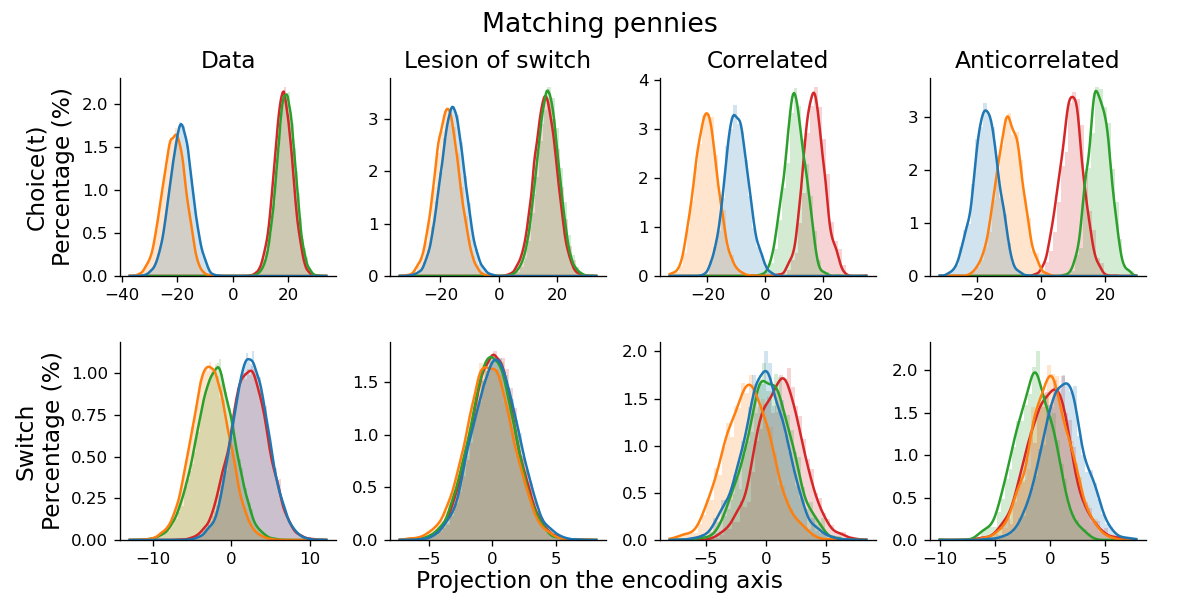

In [136]:
plot_projection_dist(MP_Projection,MP_Projection_df[MP_Projection_df.Corrcoef==corrcoef[0]],
                     MP_Projection_df[MP_Projection_df.Corrcoef==corrcoef[-1]],'MP')

In [ ]:
MP_BD.to_csv('MP surrogate dprime', sep=',', index=False, encoding='utf-8')

In [127]:
MP_Projection.to_csv('MP surrogate projection', sep=',', index=False, encoding='utf-8')

In [20]:
PRL_BD.to_csv('PRL surrogate dprime', sep=',', index=False, encoding='utf-8')

In [128]:
PRL_Projection.to_csv('PRL surrogate projection', sep=',', index=False, encoding='utf-8')

In [100]:
MP_BD_df.to_csv('MP surrogate correlation dprime', sep=',', index=False, encoding='utf-8')

In [117]:
MP_Projection_df.to_csv('MP surrogate correlation projection', sep=',', index=False, encoding='utf-8')

In [101]:
MP_BD_df_pre.to_csv('MP surrogate correlation dprime pre', sep=',', index=False, encoding='utf-8')

In [118]:
MP_Projection_df_pre.to_csv('MP surrogate correlation projection pre', sep=',', index=False, encoding='utf-8')

In [102]:
PRL_BD_df.to_csv('PRL surrogate correlation dprime', sep=',', index=False, encoding='utf-8')

In [119]:
PRL_Projection_df.to_csv('PRL surrogate correlation projection', sep=',', index=False, encoding='utf-8')

In [103]:
PRL_BD_df_pre.to_csv('PRL surrogate correlation dprime pre', sep=',', index=False, encoding='utf-8')

In [120]:
PRL_Projection_df_pre.to_csv('PRL surrogate correlation projection pre', sep=',', index=False, encoding='utf-8')

In [73]:
MP_BD = pd.read_csv('MP surrogate dprime', sep=',')

In [83]:
MP_corr_BD = pd.read_csv('MP surrogate correlation dprime', sep=',')

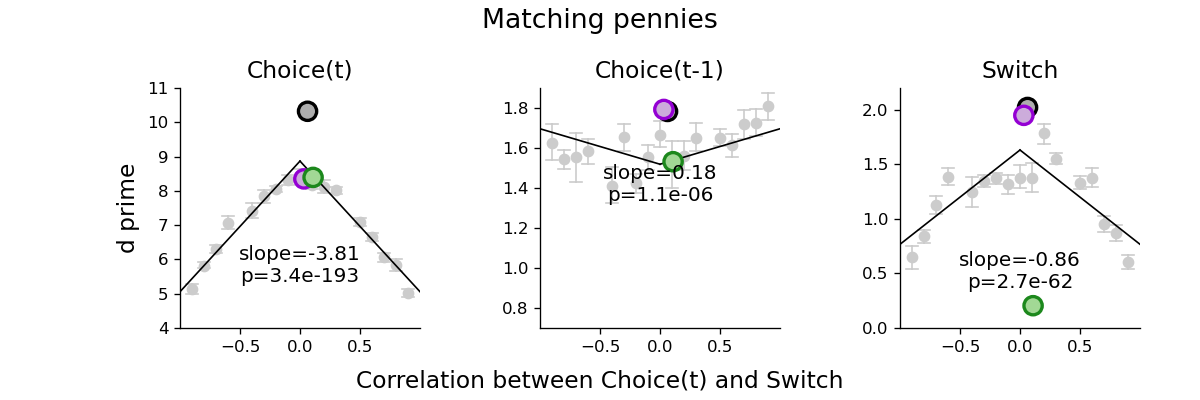

In [84]:
plot_reorder(MP_corr_BD,MP_BD, 'Matching pennies','MP correlation BD grouped.svg','MP')

In [86]:
PRL_BD = pd.read_csv('PRL surrogate dprime', sep=',')

In [96]:
PRL_corr_BD = pd.read_csv('PRL surrogate correlation dprime', sep=',')

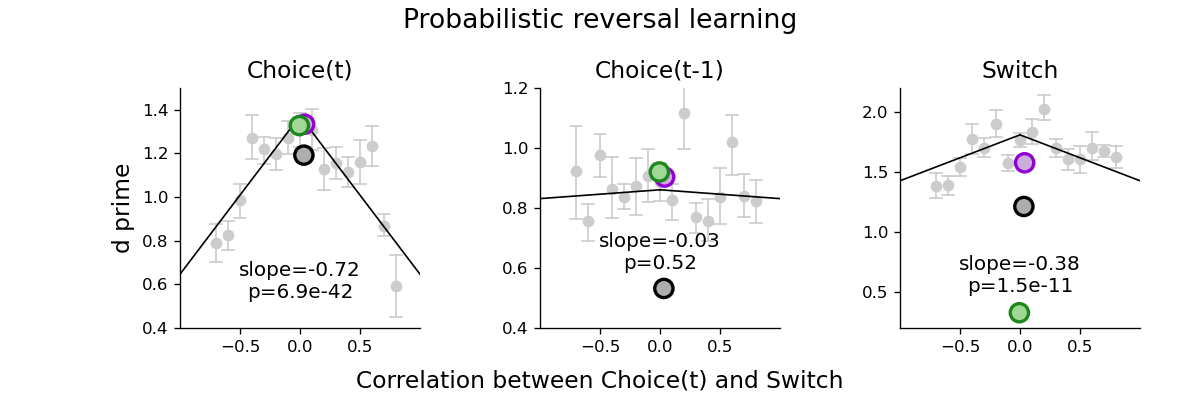

In [97]:
plot_reorder(PRL_corr_BD,PRL_BD, 'Probabilistic reversal learning','PRL correlation BD grouped.svg','PRL')

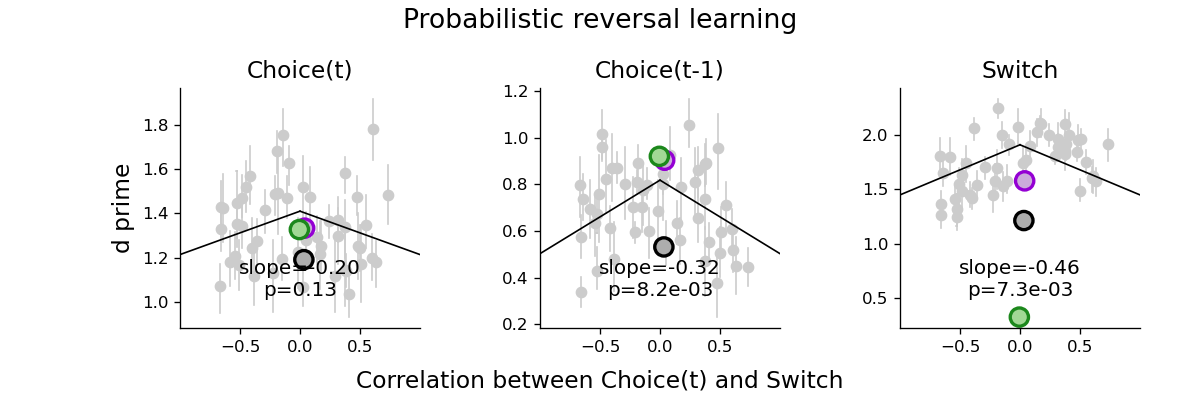

In [123]:
plot_reorder(PRL_BD_df_pre,PRL_BD, 'Probabilistic reversal learning','PRL correlation BD pre.svg')

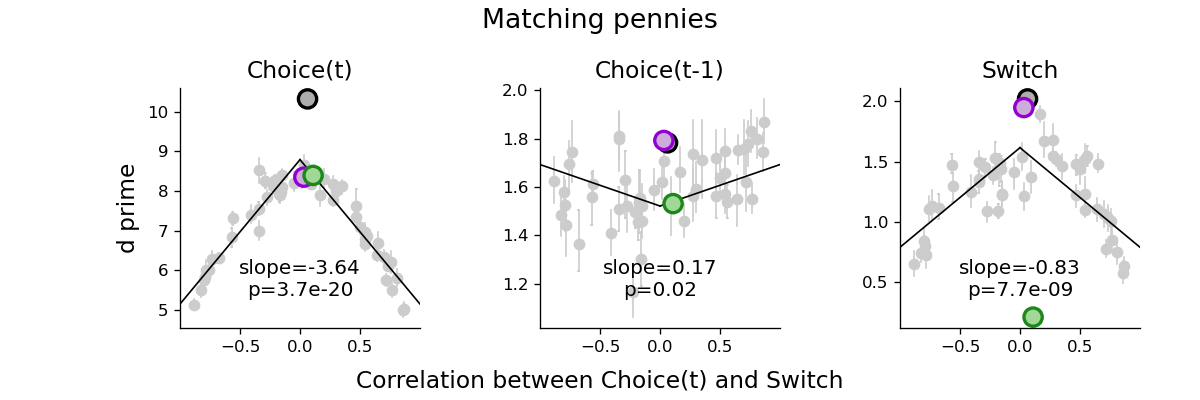

In [124]:
plot_reorder(MP_BD_df,MP_BD, 'Matching pennies','MP correlation BD.svg')

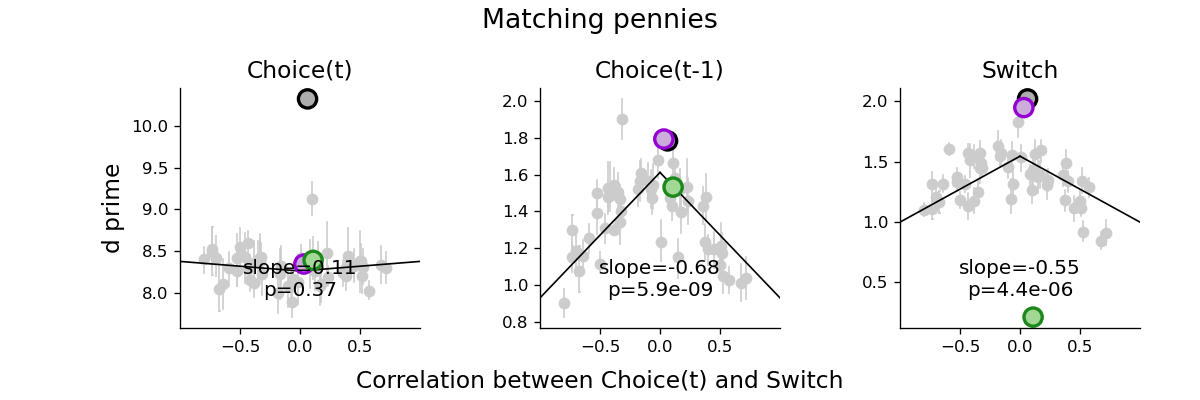

In [125]:
plot_reorder(MP_BD_df_pre,MP_BD, 'Matching pennies','MP correlation BD pre.svg')

In [94]:
def plot_reorder(corr_acc,rem_acc,title,filename,task):
    
    
    plt.close('all')
    plt.rcParams['svg.fonttype'] = 'none'
    my_dpi = 120
    fig = plt.figure(figsize=(1200/my_dpi, 400/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(1,3)
    titles=['Choice(t)','Choice(t-1)','Switch']
    variables=['Current','Previous','Switch']
    
    if task=='MP':
        yl=[[4,11],[0.7,1.9],[0,2.2]]
    if task=='PRL':
        yl=[[0.4,1.5],[0.4,1.2],[0.2,2.2]]
        
    corr_acc['group']=pd.cut(corr_acc.Corrcoef,np.linspace(-0.95,0.95,20),labels=np.linspace(-0.9,0.9,19)).to_numpy()
    
    for c in range(3):
        
        ax = plt.subplot(gs[c])   
        sns.pointplot(corr_acc,x='group',y=variables[c],color=[0.8,0.8,0.8],ax=ax,native_scale=True,
                             linestyle="none", markersize=5, 
                                errorbar=("ci", 95), capsize=1,
                                err_kws={'linewidth':1, 'color':[0.8,0.8,0.8]},zorder=1)
        
        mdl=sm.OLS(corr_acc[variables[c]].values,sm.add_constant(np.abs(corr_acc.Corrcoef.values)))
        res = mdl.fit()
        x=[0,1]
        y=res.predict(sm.add_constant(x))
        plt.plot(x,y,color='k',linewidth=1,zorder=1)  
        x=[-1,0]
        ax.plot(x,np.flip(y),color='k',linewidth=1,zorder=1)   
        
        sns.scatterplot(rem_acc.groupby('Method').mean(),
                        edgecolor=['k','#9400D3','#1C881C'],legend=False,
                palette=['#ADADAD','#CCACDB','#A2D895'],s=120,lw=2,
                x='Corrcoef',y=variables[c],hue='Method',alpha=1)

        if c==0:
            pos=[0.8,0.2]
        if c==1:
            pos=[0.9,0.1]
        if c==2:
            pos=[0.75,0.25]
            
        pos=[0.8,0.2]
        
        if res.pvalues[1]<0.01:
            ax.text(0,np.dot(ax.get_ylim(),pos),'slope='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.1e}",
                    fontsize=12,ha='center',va='center')
        else:
            ax.text(0,np.dot(ax.get_ylim(),pos),'slope='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.2f}",
                    fontsize=12,ha='center',va='center')

        if c==0:
            # ax.set_ylabel('Accuracy (%)', fontsize=14)
            ax.set_ylabel('d prime', fontsize=14)
        else:
            ax.set_ylabel('')
                          
        ax.set_title(titles[c],fontsize=14)
        ax.set_position([c*0.9/3+0.15,0.18,0.2,0.6])
        ax.set_xticks([-0.5,0,0.5])
        ax.set_xlabel('')
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_ylim(yl[c])
        ax.set_xlim(-1,1)
        
    fig.text(0.5, 0.03, 'Correlation between Choice(t) and Switch', ha='center', fontsize=14)
    
    plt.suptitle(title,fontsize=16)
    plt.savefig(filename,format = 'svg', dpi=120)
#     plt.savefig(filename,format = 'png', dpi=120)

In [69]:
def plot_reorder(corr_acc,rem_acc,title,filename):
    
    
    plt.close('all')
    plt.rcParams['svg.fonttype'] = 'none'
    my_dpi = 120
    fig = plt.figure(figsize=(1200/my_dpi, 400/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(1,3)
    titles=['Choice(t)','Choice(t-1)','Switch']
    variables=['Current','Previous','Switch']

    for c in range(3):
        
        ax = plt.subplot(gs[c])   
        sns.scatterplot(corr_acc,x='Corrcoef',y=variables[c],color=[0.8,0.8,0.8],s=80,ax=ax)
        
        mdl=sm.OLS(corr_acc[variables[c]].values,sm.add_constant(np.abs(corr_acc.Corrcoef.values)))
        res = mdl.fit()
        x=[0,1]
        y=res.predict(sm.add_constant(x))
        plt.plot(x,y,color='k',linewidth=1,zorder=1)  
        x=[-1,0]
        ax.plot(x,np.flip(y),color='k',linewidth=1,zorder=1)   
        
        sns.scatterplot(rem_acc.groupby('Method').mean(),
                        edgecolor=['k','#9400D3','#1C881C'],legend=False,
                palette=['#ADADAD','#CCACDB','#A2D895'],s=120,lw=2,
                x='Corrcoef',y=variables[c],hue='Method')

        if c==0:
            pos=[0.8,0.2]
        if c==1:
            pos=[0.9,0.1]
        if c==2:
            pos=[0.75,0.25]
            
        pos=[0.8,0.2]
        
        if res.pvalues[1]<0.01:
            ax.text(0,np.dot(ax.get_ylim(),pos),'w='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.1e}",
                    fontsize=12,ha='center',va='center')
        else:
            ax.text(0,np.dot(ax.get_ylim(),pos),'w='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.2f}",
                    fontsize=12,ha='center',va='center')

        ax.set_xlim(-1,1)

        if c==0:
            # ax.set_ylabel('Accuracy (%)', fontsize=14)
            ax.set_ylabel('d prime', fontsize=14)
        else:
            ax.set_ylabel('')
                          
        ax.set_title(titles[c],fontsize=14)
        ax.set_position([c*0.9/3+0.15,0.18,0.2,0.6])
        ax.set_xticks([-0.5,0,0.5])
        ax.set_xlabel('')
        ax.spines[['right', 'top']].set_visible(False)

        
    fig.text(0.5, 0.03, 'Correlation between Choice(t) and Switch', ha='center', fontsize=14)
    
    plt.suptitle(title,fontsize=16)
    plt.savefig(filename,format = 'svg', dpi=120)
#     plt.savefig(filename,format = 'png', dpi=120)

In [27]:
def plot_reorder_binned(corr_acc,rem_acc,title,filename):
    
    
    plt.close('all')
    plt.rcParams['svg.fonttype'] = 'none'
    my_dpi = 120
    fig = plt.figure(figsize=(1200/my_dpi, 400/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(1,3)
    titles=['Choice(t)','Choice(t-1)','Switch']
    variables=['Current','Previous','Switch']

    for c in range(3):
        
        ax = plt.subplot(gs[c])   
        sns.scatterplot(corr_acc,x='Corrcoef',y=variables[c],color=[0.8,0.8,0.8],s=40,ax=ax)
        
        mdl=sm.OLS(corr_acc[variables[c]].values,sm.add_constant(np.abs(corr_acc.Corrcoef.values)))
        res = mdl.fit()
        x=[0,1]
        y=res.predict(sm.add_constant(x))
        plt.plot(x,y,color='k',linewidth=1,zorder=1)  
        x=[-1,0]
        ax.plot(x,np.flip(y),color='k',linewidth=1,zorder=1)   
        
        sns.scatterplot(rem_acc.groupby('Method').mean(),
                        edgecolor=['k','#9400D3','#1C881C'],legend=False,
                palette=['#ADADAD','#CCACDB','#A2D895'],s=120,lw=2,
                x='Corrcoef',y=variables[c],hue='Method')

        if c==0:
            pos=[0.8,0.2]
        if c==1:
            pos=[0.9,0.1]
        if c==2:
            pos=[0.75,0.25]
            
        pos=[0.8,0.2]
        
        if res.pvalues[1]<0.01:
            ax.text(0,np.dot(ax.get_ylim(),pos),'w='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.1e}",
                    fontsize=12,ha='center',va='center')
        else:
            ax.text(0,np.dot(ax.get_ylim(),pos),'w='+f"{res.params[1]:.2f}"+'\np='+f"{res.pvalues[1]:.2f}",
                    fontsize=12,ha='center',va='center')

        ax.set_xlim(-1,1)

        if c==0:
            # ax.set_ylabel('Accuracy (%)', fontsize=14)
            ax.set_ylabel('d prime', fontsize=14)
        else:
            ax.set_ylabel('')
                          
        ax.set_title(titles[c],fontsize=14)
        ax.set_position([c*0.9/3+0.15,0.18,0.2,0.6])
        ax.set_xticks([-0.5,0,0.5])
        ax.set_xlabel('')
        ax.spines[['right', 'top']].set_visible(False)

        
    fig.text(0.5, 0.03, 'Correlation between Choice(t) and Switch', ha='center', fontsize=14)
    
    plt.suptitle(title,fontsize=16)
    plt.savefig(filename,format = 'svg', dpi=120)
#     plt.savefig(filename,format = 'png', dpi=120)

In [ ]:
MP_BD = pd.read_csv('MP surrogate correlation dprime', sep=',')
PRL_BD = pd.read_csv('PRL surrogate correlation dprime', sep=',')

In [ ]:
mdl=sm.OLS(MP_BD['Current'].values,sm.add_constant(np.abs(MP_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
mdl=sm.OLS(MP_BD['Previous'].values,sm.add_constant(np.abs(MP_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
mdl=sm.OLS(MP_BD['Switch'].values,sm.add_constant(np.abs(MP_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
mdl=sm.OLS(PRL_BD['Current'].values,sm.add_constant(np.abs(PRL_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
mdl=sm.OLS(PRL_BD['Previous'].values,sm.add_constant(np.abs(PRL_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
mdl=sm.OLS(PRL_BD['Switch'].values,sm.add_constant(np.abs(PRL_BD[['CurrentCoef', 'SwitchCoef','Corrcoef']].values)))
res = mdl.fit()
res.pvalues

In [ ]:
PRL_df = pd.melt(PRL_accuracy, id_vars=['Time','Method'], value_vars=['Current', 'Previous','Switch','Choice Sequence'])

In [ ]:
_, _, _, df1 = simulation_correlated(PRL[(PRL.area==0) & (PRL.Volatility==1)],
                        'Col',PRL_regressors,[6],[-1], num_iter=100)
_, _, _, df2 = simulation_correlated(PRL[(PRL.area==0) & (PRL.Volatility==1)],
                        'Col',PRL_regressors,[6],[1], num_iter=100)

In [ ]:
_, _, _, df3 = simulation_correlated(MP[MP.area==0],
                        'Loc',MP_regressors,[10],[-1], num_iter=100)
_, _, _, df4 = simulation_correlated(MP[MP.area==0],
                        'Loc',MP_regressors,[10],[1], num_iter=100)

In [ ]:
plot_projection_dist(PRL_Projection,df1,df2,'PRL')

In [ ]:
plot_projection_dist(MP_Projection,df3,df4,'MP')

In [135]:
def plot_projection_dist(df,df1,df2,task):

    plt.close('all')
    plt.rcParams['svg.fonttype'] = 'none'
    my_dpi = 120
    fig = plt.figure(figsize=(1200/my_dpi, 600/my_dpi), dpi=my_dpi,facecolor=(1, 1, 1))
    gs = gridspec.GridSpec(2,4)
    variables=['CurrentProjection','SwitchProjection']
    w=0.18
    h=0.33
    v=0.1

    data_d = df[df.Method==0].copy()

    for vv in range(2):
        ax = plt.subplot(gs[vv,0])
        sns.histplot(data=data_d,x=variables[vv],ax=ax,
                     hue=data_d[['Current', 'Switch']].apply(tuple, axis=1),
                     legend=False,stat='percent',bins=100,multiple='dodge',element='step',
                     linewidth=0,kde=True,alpha=0.2)
        ax.set_xlabel('')
        if vv==0:
            ax.set_title('Data',fontsize=14)
            ax.set_ylabel('Choice(t)\nPercentage (%)', fontsize=14)
        else:
            ax.set_ylabel('Switch\nPercentage (%)', fontsize=14)
        ax.set_position([0.9/4*0+0.1,v+0.44*(1-vv),w,h])
        ax.spines[['right', 'top']].set_visible(False)


    removal_d = df[df.Method==2].copy()

    for vv in range(2):
        ax = plt.subplot(gs[vv,1])
        sns.histplot(data=removal_d,x=variables[vv],ax=ax,
                     hue=removal_d[['Current', 'Switch']].apply(tuple, axis=1),
                     legend=False,stat='percent',bins=50,multiple='dodge',element='step',
                     linewidth=0,kde=True,alpha=0.2)
        ax.set_ylabel('')
        ax.set_xlabel('')
        if vv==0:
            ax.set_title('Lesion of switch',fontsize=14)
        ax.set_position([0.9/4*1+0.1,v+0.44*(1-vv),w,h])
        ax.spines[['right', 'top']].set_visible(False)

        
            
    for vv in range(2):
        ax = plt.subplot(gs[vv,2])
        sns.histplot(data=df2,x=variables[vv],ax=ax,
                 hue=df2[['Current', 'Switch']].apply(tuple, axis=1),
                 legend=False,stat='percent',bins=50,multiple='dodge',element='step',
                 linewidth=0,kde=True,alpha=0.2)
        ax.set_ylabel('')
        ax.set_xlabel('')
        if vv==0:
            ax.set_title('Correlated',fontsize=14)

        ax.set_position([0.9/4*2+0.1,v+0.44*(1-vv),w,h])
        ax.spines[['right', 'top']].set_visible(False)

            
            
    for vv in range(2):
        ax = plt.subplot(gs[vv,3])
        sns.histplot(data=df1,x=variables[vv],ax=ax,
                 hue=df1[['Current', 'Switch']].apply(tuple, axis=1),
                 legend=False,stat='percent',bins=50,multiple='dodge',element='step',
                 linewidth=0,kde=True,alpha=0.2)
        ax.set_ylabel('')
        ax.set_xlabel('')
        if vv==0:
            ax.set_title('Anticorrelated',fontsize=14)
        ax.set_position([0.9/4*3+0.1,v+0.44*(1-vv),w,h])
        ax.spines[['right', 'top']].set_visible(False)

            
    fig.text(0.5, 0.02, 'Projection on the encoding axis', ha='center', fontsize=14)
    if task=='PRL':
        plt.suptitle('Probablistic reversal learning',fontsize=16)
    if task=='MP':
        plt.suptitle('Matching pennies',fontsize=16)
    plt.savefig(task+' projection distribution.svg',format = 'svg', dpi=120)